In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [2]:
config = pd.Series({
    'path': os.path.abspath('../dades'),
    'file_type':'csv',
    'years':[2023],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:40167 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 16.44 GB


# Read data

In [4]:
%%time

data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 107 ms, sys: 36.9 ms, total: 144 ms
Wall time: 139 ms


# 2023

In [7]:
config_year = pd.Series({
    'path':config.path,
    'file_type':config.file_type,
    'year':2023,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [8]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

6

In [9]:
first_size = get_ddf_shape(data[config_year.year])

In [10]:
data[config_year.year]

,station_id,num_bikes_available,num_bikes_available_types.mechanical,num_bikes_available_types.ebike,num_docks_available,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,last_updated,year_last_updated_date,month_last_updated_date,dayofweek_last_updated_date,dayofmonth_last_updated_date,dayofyear_last_updated_date,hour_last_updated_date
npartitions=5,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Preprocessing

In [12]:
%%time

# do not execute everytime, takes 17s and eat the memory. Once executed disable the cell and restart the notebook. Since this cell saves a checkpoint you can continue without it.

data[config_year.year] = data[config_year.year].drop(['traffic', 'last_reported'], axis=1)

data[config_year.year]['station_id']=data[config_year.year]['station_id'].astype(int)
data[config_year.year]['is_charging_station']=data[config_year.year]['is_charging_station'].astype(int)
data[config_year.year]['last_updated']=data[config_year.year]['last_updated'].astype(int)
data[config_year.year]['year_last_updated_date']=data[config_year.year]['year_last_updated_date'].astype(int)
data[config_year.year]['month_last_updated_date']=data[config_year.year]['month_last_updated_date'].astype(int)
data[config_year.year]['dayofweek_last_updated_date']=data[config_year.year]['dayofweek_last_updated_date'].astype(int)
data[config_year.year]['dayofmonth_last_updated_date']=data[config_year.year]['dayofmonth_last_updated_date'].astype(int)
data[config_year.year]['dayofyear_last_updated_date']=data[config_year.year]['dayofyear_last_updated_date'].astype(int)
data[config_year.year]['hour_last_updated_date']=data[config_year.year]['hour_last_updated_date'].astype(int)

data[config_year.year]['status']=data[config_year.year]['status'].round().astype(int)
data[config_year.year]['is_installed']=data[config_year.year]['is_installed'].round().astype(int)
data[config_year.year]['is_renting']=data[config_year.year]['is_renting'].round().astype(int)
data[config_year.year]['is_returning']=data[config_year.year]['is_returning'].round().astype(int)

# Found two station with alot of missing values 
# best solution is to remove
# condition = (data[config_year.year]['station_id'].isin([520.0, 527.0, 532.0]))
# data[config_year.year] = data[config_year.year].mask(condition, np.nan)
# data[config_year.year] = data[config_year.year].dropna(subset=['station_id'])

last_size = get_ddf_shape(data[config_year.year])

new_columns = {
    'last_updated': 'timestamp',
    'year_last_updated_date':'year', 
    'month_last_updated_date':'month',
    'dayofweek_last_updated_date':'dayofweek', 
    'dayofmonth_last_updated_date':'day', 
    'dayofyear_last_updated_date':'dayofyear',
    'hour_last_updated_date':'hour'
}

data[config_year.year] = data[config_year.year].rename(columns=new_columns)

CPU times: user 313 ms, sys: 24 ms, total: 337 ms
Wall time: 1.21 s


In [13]:
save_checkpoint(data[config_year.year], config_year)

# checkpoint saved.
# CPU times: user 2.12 s, sys: 250 ms, total: 2.37 s
# Wall time: 17.3 s

checkpoint saved.


In [17]:
%%time

data[config_year.year] = load_checkpoint(config_year)

# checkpoint reloaded.

checkpoint reloaded.
CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 12 ms


In [18]:
%%time

last_size = get_ddf_shape(data[config_year.year])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(last_size[0]-first_size[0]):02d} rows')
print(f'dropped {(last_size[1]-first_size[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed 00 rows
dropped -2 columns
CPU times: user 26.4 ms, sys: 20.3 ms, total: 46.6 ms
Wall time: 422 ms


In [19]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

6

In [20]:
%%time

nans = get_features_nans(data[config_year.year])

zeros = get_features_zero(data[config_year.year])

CPU times: user 175 ms, sys: 29.5 ms, total: 204 ms
Wall time: 1.84 s


In [21]:
nans

{}

In [22]:
zeros

{'num_bikes_available': 1.599185659314522,
 'num_bikes_available_types.mechanical': 15.81670740725041,
 'num_bikes_available_types.ebike': 11.234039346455098,
 'num_docks_available': 0.5378699033058747,
 'status': 99.93824151394836,
 'is_installed': 0.0005298630833792549,
 'is_renting': 0.07076615846909604,
 'is_returning': 0.070707284793165,
 'dayofweek': 14.147285452550173,
 'hour': 4.06893636462116}

In [23]:
# nuniques = get_columns_nunique(data[config_year.year])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# timestamp                                  8700
# year                                          2
# month                                        12
# week                                         53
# dayofweek                                     7
# day                                          31
# dayofyear                                   366
# hour                                         24
# traffic                                    1741
# dtype: int64
    
uniques = get_columns_unique(data[config_year.year])

In [24]:
uniques

{'station_id': 0        1
 1       34
 2      386
 3      385
 4      384
       ... 
 503    249
 504    519
 505    106
 506    520
 507    191
 Name: station_id, Length: 508, dtype: int64,
 'num_bikes_available': 0       38.000000
 1       37.333333
 2       38.800000
 3       38.500000
 4       39.500000
           ...    
 4330     9.062500
 4331    35.928571
 4332    31.777778
 4333    27.045455
 4334    19.055556
 Name: num_bikes_available, Length: 4335, dtype: float64,
 'num_bikes_available_types.mechanical': 0       35.000000
 1       36.600000
 2       37.375000
 3       37.666667
 4       38.500000
           ...    
 3633    12.954545
 3634    18.687500
 3635    24.590909
 3636    17.277778
 3637    14.133333
 Name: num_bikes_available_types.mechanical, Length: 3638, dtype: float64,
 'num_bikes_available_types.ebike': 0        3.000000
 1        2.333333
 2        2.200000
 3        1.125000
 4        1.833333
           ...    
 2613    28.545455
 2614     9.437500
 2615  

### Finding max capacity for a station

In [25]:
%%time

print(stats.describe(data[config_year.year].num_docks_available))
data[config_year.year].num_docks_available.describe().compute()

DescribeResult(nobs=1698552, minmax=(0.0, 54.0), mean=15.62662082901828, variance=66.58877255025749, skewness=0.2350978885297382, kurtosis=0.07173308496891728)
CPU times: user 169 ms, sys: 42.4 ms, total: 211 ms
Wall time: 929 ms


count    1.698552e+06
mean     1.562662e+01
std      8.160194e+00
min      0.000000e+00
25%      1.000000e+01
50%      1.612500e+01
75%      2.183333e+01
max      5.400000e+01
Name: num_docks_available, dtype: float64

In [26]:
%%time

print(stats.describe(data[config_year.year].num_bikes_available))
data[config_year.year].num_bikes_available.describe().compute()

DescribeResult(nobs=1698552, minmax=(0.0, 54.0), mean=10.6491388962594, variance=60.93311989962463, skewness=0.8673548775950212, kurtosis=0.9000157689917976)
CPU times: user 193 ms, sys: 4.41 ms, total: 198 ms
Wall time: 906 ms


count    1.698552e+06
mean     1.064914e+01
std      7.805967e+00
min      0.000000e+00
25%      5.000000e+00
50%      1.016667e+01
75%      1.600000e+01
max      5.400000e+01
Name: num_bikes_available, dtype: float64

In [27]:
%%time

print(stats.describe(data[config_year.year]['num_bikes_available_types.mechanical']))
data[config_year.year]['num_bikes_available_types.mechanical'].describe().compute()

DescribeResult(nobs=1698552, minmax=(0.0, 54.0), mean=6.9852084021519705, variance=48.56796257906078, skewness=1.1641800896916106, kurtosis=1.4167127374829276)
CPU times: user 210 ms, sys: 0 ns, total: 210 ms
Wall time: 949 ms


count    1.698552e+06
mean     6.985208e+00
std      6.969072e+00
min      0.000000e+00
25%      1.166667e+00
50%      5.500000e+00
75%      1.159318e+01
max      5.400000e+01
Name: num_bikes_available_types.mechanical, dtype: float64

In [28]:
print(stats.describe(data[config_year.year]['num_bikes_available_types.ebike']))
data[config_year.year]['num_bikes_available_types.ebike'].describe().compute()

DescribeResult(nobs=1698552, minmax=(0.0, 45.14285714285714), mean=3.6729377525412734, variance=19.221942207146498, skewness=1.9469920562438783, kurtosis=4.360324147434226)


count    1.698552e+06
mean     3.672938e+00
std      4.384284e+00
min      0.000000e+00
25%      8.000000e-01
50%      2.400000e+00
75%      6.000000e+00
max      4.514286e+01
Name: num_bikes_available_types.ebike, dtype: float64

correct data 1691783 incorrect data 6769
CPU times: user 543 ms, sys: 57.4 ms, total: 600 ms
Wall time: 2.86 s


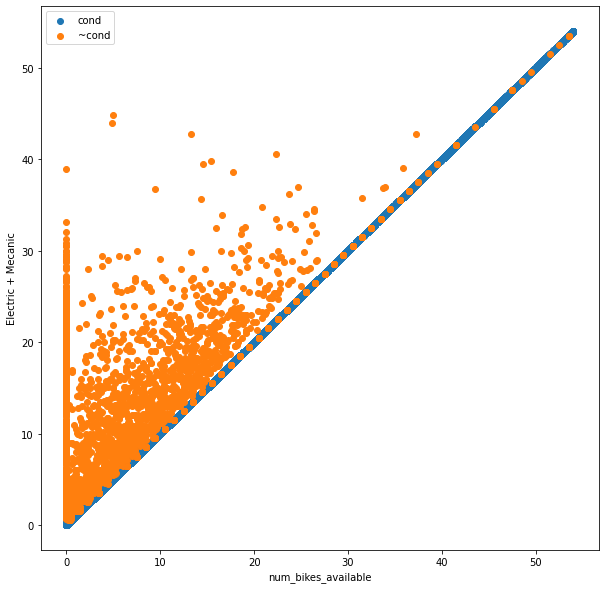

In [29]:
%%time

cond = data[config_year.year].num_bikes_available.round().astype(int) == (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']).round().astype(int)

print('correct data',data[config_year.year][cond].shape[0].compute(), 'incorrect data', data[config_year.year][~cond].shape[0].compute())
    
plt.rcParams["figure.figsize"] = (10,10)
    
plt.scatter(
    data[config_year.year][cond].num_bikes_available.compute(), 
    (data[config_year.year][cond]['num_bikes_available_types.ebike'] + data[config_year.year][cond]['num_bikes_available_types.mechanical']).compute(),
    label='cond'
)

plt.scatter(
    data[config_year.year][~cond].num_bikes_available.compute(), 
    (data[config_year.year][~cond]['num_bikes_available_types.ebike'] + data[config_year.year][~cond]['num_bikes_available_types.mechanical']).compute(),
    label='~cond'
)

plt.ylabel('Electric + Mecanic')
plt.xlabel('num_bikes_available')
plt.legend()

In [30]:
%%time

data[config_year.year]['num_bikes_available'] = data[config_year.year]['num_bikes_available'].mask(~cond, (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']))


CPU times: user 8.14 ms, sys: 0 ns, total: 8.14 ms
Wall time: 7.58 ms


correct data 1698552 incorrect data 0
CPU times: user 688 ms, sys: 0 ns, total: 688 ms
Wall time: 3.09 s


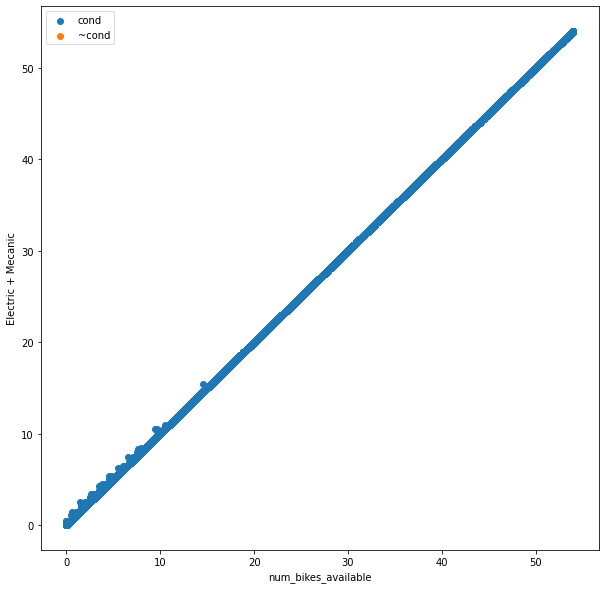

In [31]:
%%time

cond = data[config_year.year].num_bikes_available.round().astype(int) == (data[config_year.year]['num_bikes_available_types.ebike'] + data[config_year.year]['num_bikes_available_types.mechanical']).round().astype(int)

print('correct data',data[config_year.year][cond].shape[0].compute(), 'incorrect data', data[config_year.year][~cond].shape[0].compute())

plt.rcParams["figure.figsize"] = (10,10)
    
plt.scatter(
    data[config_year.year][cond].num_bikes_available.compute(), 
    (data[config_year.year][cond]['num_bikes_available_types.ebike'] + data[config_year.year][cond]['num_bikes_available_types.mechanical']).compute(),
    label='cond'
)

plt.scatter(
    data[config_year.year][~cond].num_bikes_available.compute(), 
    (data[config_year.year][~cond]['num_bikes_available_types.ebike'] + data[config_year.year][~cond]['num_bikes_available_types.mechanical']).compute(),
    label='~cond'
)

plt.ylabel('Electric + Mecanic')
plt.xlabel('num_bikes_available')
plt.legend()

In [32]:
# Now capacity of a station must be something similar to the sum of available bikes and available docks

In [33]:
%%time

data[config_year.year]['capacity'] = data[config_year.year].num_bikes_available + data[config_year.year].num_docks_available

stations_max_capacity = data[config_year.year].groupby(['station_id'])['capacity'].max().reset_index()

# drop capacity 
data[config_year.year] = data[config_year.year].drop(['capacity'], axis=1)

# merge with stations_max_capacity
data[config_year.year] = data[config_year.year].merge(stations_max_capacity.copy(), how='left', on=['station_id'])


CPU times: user 23.2 ms, sys: 0 ns, total: 23.2 ms
Wall time: 25.9 ms


In [34]:
%%time

print(stats.describe(data[config_year.year]['capacity']))
data[config_year.year]['capacity'].describe().compute()

DescribeResult(nobs=1698552, minmax=(12.000000000000004, 54.000000000000014), mean=27.07336307631442, variance=42.109389210978925, skewness=1.2948431760671975, kurtosis=3.4463824840468984)
CPU times: user 327 ms, sys: 0 ns, total: 327 ms
Wall time: 1.38 s


count    1.698552e+06
mean     2.707336e+01
std      6.489175e+00
min      1.200000e+01
25%      2.400000e+01
50%      2.700000e+01
75%      2.900000e+01
max      5.400000e+01
Name: capacity, dtype: float64

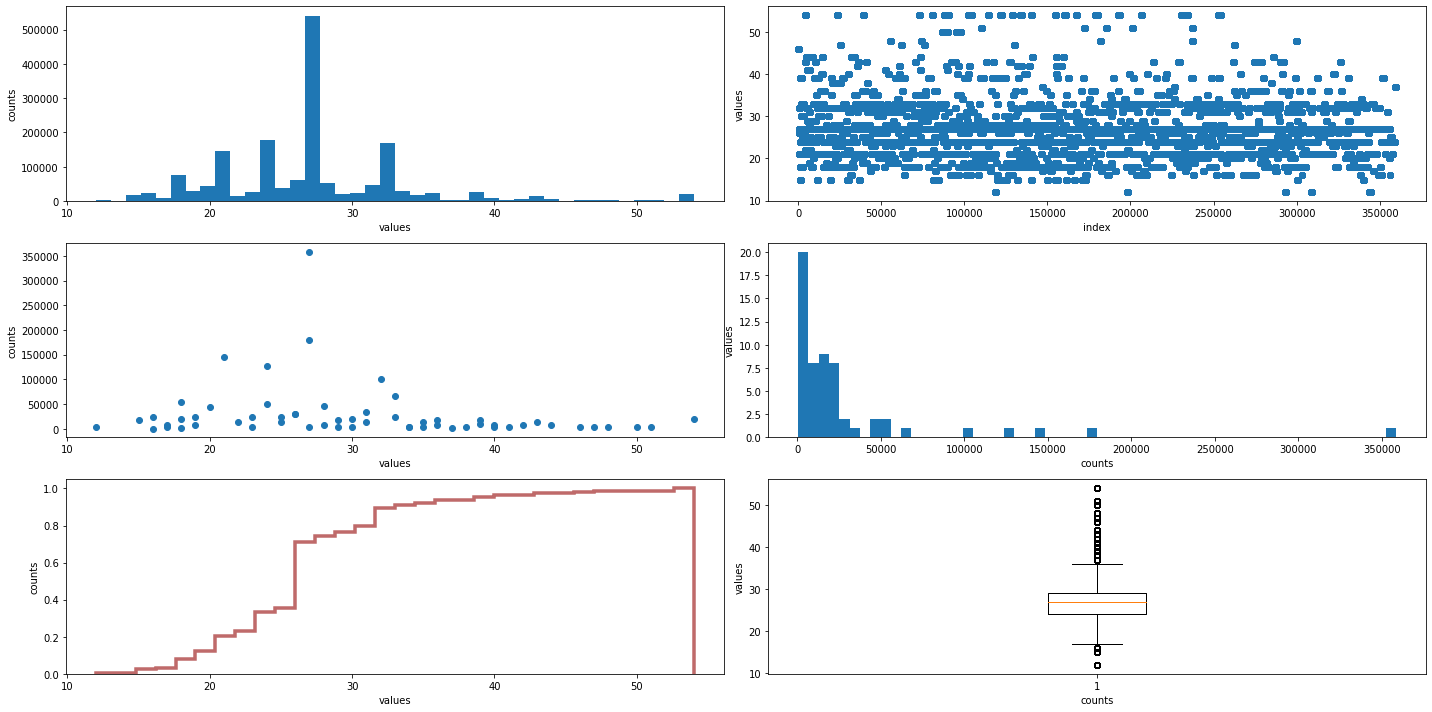

CPU times: user 3.67 s, sys: 654 ms, total: 4.32 s
Wall time: 3.59 s


In [35]:
%%time

show_counts(data[config_year.year]['capacity'].compute())

## find the percentage of docks available

In [36]:
%%time

data[config_year.year]['ctx0'] = data[config_year.year].num_docks_available / data[config_year.year].capacity


CPU times: user 7.01 ms, sys: 0 ns, total: 7.01 ms
Wall time: 6.59 ms


In [37]:
%%time

print(stats.describe(data[config_year.year]['ctx0']))
data[config_year.year]['ctx0'].describe().compute()

DescribeResult(nobs=1698552, minmax=(0.0, 1.0), mean=0.5770359210836514, variance=0.071954409157449, skewness=-0.38314440269153144, kurtosis=-0.89341548196465)
CPU times: user 266 ms, sys: 43.4 ms, total: 309 ms
Wall time: 1.4 s


count    1.698552e+06
mean     5.770359e-01
std      2.682432e-01
min      0.000000e+00
25%      3.859649e-01
50%      6.300000e-01
75%      8.221154e-01
max      1.000000e+00
Name: ctx0, dtype: float64

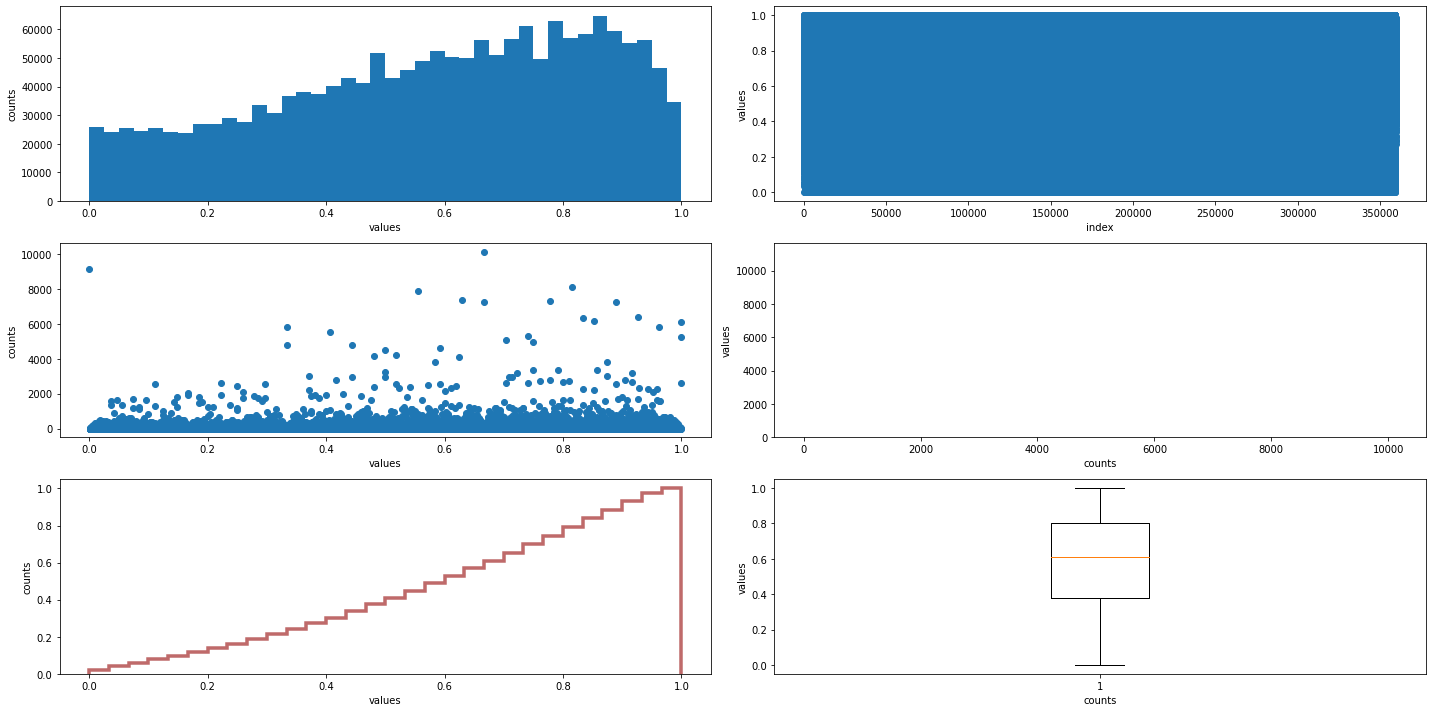

CPU times: user 1min 2s, sys: 11.8 s, total: 1min 14s
Wall time: 1min 12s


In [38]:
%%time

show_counts(data[config_year.year]['ctx0'].compute())

### Generating new columns of past 4 hours

In [39]:
%%time

ctx = data[config_year.year][['station_id', 'timestamp', 'ctx0']].copy()
# ctx = ctx.rename(columns={'num_docks_available': 'ctx0'})
print(ctx.columns)

for i in range(1,5): 
    ctx = ctx.rename(columns={f'ctx{i-1}': f'ctx{i}'})
    print(ctx.columns)
    
    ctx.timestamp = ctx.timestamp + 3600 
    data[config_year.year] = data[config_year.year].merge(ctx.copy(), how='left', on=['station_id','timestamp'])
    
    cond = data[config_year.year][f'ctx{i}'].isna()
    data[config_year.year][f'ctx{i}'] = data[config_year.year][f'ctx{i}'].mask(cond, data[config_year.year][f'ctx{i-1}'])


Index(['station_id', 'timestamp', 'ctx0'], dtype='object')
Index(['station_id', 'timestamp', 'ctx1'], dtype='object')
Index(['station_id', 'timestamp', 'ctx2'], dtype='object')
Index(['station_id', 'timestamp', 'ctx3'], dtype='object')
Index(['station_id', 'timestamp', 'ctx4'], dtype='object')
CPU times: user 175 ms, sys: 4.27 ms, total: 179 ms
Wall time: 175 ms


In [40]:
data[config_year.year].columns

Index(['station_id', 'num_bikes_available',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_charging_station', 'status', 'is_installed', 'is_renting',
       'is_returning', 'timestamp', 'year', 'month', 'dayofweek', 'day',
       'dayofyear', 'hour', 'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3',
       'ctx4'],
      dtype='object')

In [41]:
%%time

get_features_nans(data[config_year.year])

CPU times: user 5.16 s, sys: 187 ms, total: 5.35 s
Wall time: 10.2 s


{}

In [42]:
%%time

save_checkpoint(data[config_year.year], config_year)

# checkpoint saved.

checkpoint saved.
CPU times: user 973 ms, sys: 154 ms, total: 1.13 s
Wall time: 11.9 s
